In [ ]:
# using pydrive library to download dataset from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# download the dataset 
download = drive.CreateFile({'id': '1T5K_VxUMlEfqKIljZzJJZmz92TJY_MEk'})  
download.GetContentFile('dataset.zip')

In [ ]:
# unzip the dataset
!unzip /content/dataset.zip -d /content/data

Archive:  /content/dataset.zip
   creating: /content/data/training/
   creating: /content/data/training/images/
  inflating: /content/data/training/images/img11.png  
  inflating: /content/data/training/images/img12.png  
  inflating: /content/data/training/images/img13.png  
  inflating: /content/data/training/images/img14.png  
  inflating: /content/data/training/images/img15.png  
  inflating: /content/data/training/images/img16.png  
  inflating: /content/data/training/images/img17.png  
  inflating: /content/data/training/images/img18.png  
  inflating: /content/data/training/images/img19.png  
  inflating: /content/data/training/images/img20.png  
  inflating: /content/data/training/images/img21.png  
  inflating: /content/data/training/images/img22.png  
  inflating: /content/data/training/images/img23.png  
  inflating: /content/data/training/images/img24.png  
  inflating: /content/data/training/images/img25.png  
  inflating: /content/data/training/images/img26.png  
  inflat

In [ ]:
# import the libraries that we need
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras import layers, models
import sys

Using TensorFlow backend.


In [ ]:
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, images_path1, images_path2, mask_path1, 
                 mask_path2, batch_size=16, image_dimensions = (256 ,256 ,3)):

        self.mask_path1 = mask_path1
        self.mask_path2 = mask_path2
        self.images_path1 = images_path1
        self.images_path2 = images_path2
        self.images_list1  = os.listdir(images_path1)
        self.images_list2  = os.listdir(images_path2)
        self.mask1_list  = os.listdir(mask_path1)
        self.mask2_list  = os.listdir(mask_path2)
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.images_list1) / self.batch_size))

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images_list1))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]


        # select data and load images
        mask1 = tf.convert_to_tensor([cv2.imread(os.path.join(self.mask_path1, 
                                                              self.mask1_list[k]), cv2.IMREAD_GRAYSCALE)/255.0 for k in indexes],dtype=tf.float32)
        mask2 = tf.convert_to_tensor([cv2.imread(os.path.join(self.mask_path2, 
                                                              self.mask2_list[k]), cv2.IMREAD_GRAYSCALE)/255.0 for k in indexes],dtype=tf.float32)
        image1 = tf.convert_to_tensor([cv2.imread(os.path.join(self.images_path1, 
                                                               self.images_list1[k]), cv2.IMREAD_GRAYSCALE)/255.0 for k in indexes], dtype=tf.float32)
        image2 = tf.convert_to_tensor([cv2.imread(os.path.join(self.images_path2, 
                                                               self.images_list2[k]), cv2.IMREAD_GRAYSCALE)/255.0 for k in indexes], dtype=tf.float32)
        
        return [image1, image2], [mask1, mask2]
        
   

In [ ]:
# training data generator
train_input_1 = '/content/data/training/images'
train_input_2 = '/content/data/training/transform'
train_mask1 = '/content/data/training/mask_lung'
train_mask2 = '/content/data/training/mask_infection'
train_generator = DataGenerator(train_input_1, train_input_2, train_mask1, train_mask2)

Text(0.5, 1.0, 'mask infection')

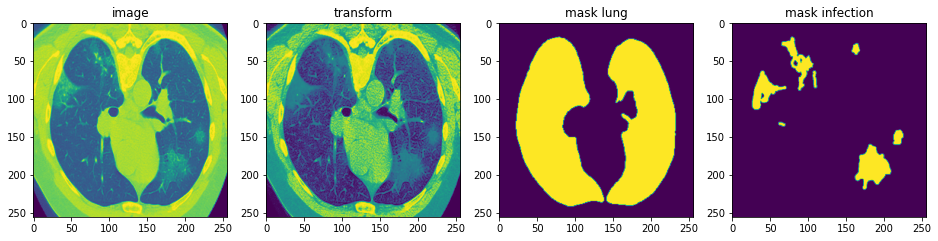

In [ ]:
# plot first sample
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow( train_generator[0][0][0][0] )
plt.title('image')
plt.subplot(142)
plt.imshow( train_generator[0][0][1][0] )
plt.title('transform')
plt.subplot(143)
plt.imshow( train_generator[0][1][0][0] )
plt.title('mask lung')
plt.subplot(144)
plt.imshow( train_generator[0][1][1][0] )
plt.title('mask infection')

In [ ]:
# validation data generator
val_input_1 = '/content/data/validation/images'
val_input_2 = '/content/data/validation/transform'
val_mask1 = '/content/data/validation/mask_lung'
val_mask2 = '/content/data/validation/mask_infection'
val_generator = DataGenerator(val_input_1, val_input_2, val_mask1, val_mask2)

In [ ]:
def encoder(input_x):
  '''encoding block
    Input:
        input_x = tensor4d, (no_samples, no_rows, no_cols, no_feats)
    Output:
        x4_en = tensor4d, (no_samples, no_rows, no_cols, no_new_feats)
    '''

  x1_en = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_x)
  x2_en = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x1_en)
  x3_en = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x2_en)
  x4_en = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x3_en)

  return x4_en

In [ ]:
def decoder(input_x, name='name'):
  '''decoding block
    Input:
        input_x = tensor4d, (no_samples, no_rows, no_cols, no_feats)
    Output:
        x4_de = tensor4d, (no_samples, no_rows, no_cols, no_new_feats)
    '''
 
  x1_de = tf.keras.layers.UpSampling2D(size=(2,2))(input_x)
  x2_de = tf.keras.layers.Conv2D(4, (3,3), activation='relu', padding='same')(x1_de)
  x3_de = tf.keras.layers.UpSampling2D(size=(2,2))(x2_de)
  x4_de = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same', name=name)(x3_de)

  return x4_de

In [ ]:
# model inputs
input1 = tf.keras.Input( shape=(256, 256, 1), name='in_1')
input2 = tf.keras.Input( shape=(256, 256, 1), name='in_2')

# encoding banch 1
FB1 = encoder(input1)
# encoding banch 2
FB2 = encoder(input2)


# concatination and convolution 
x_concat = tf.keras.layers.Concatenate(axis=-1)([FB1, FB2])
dec_in = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x_concat)


# decoding branch 1
DE_B1 = decoder(dec_in, name='output_1')
# decoding branch 2
DE_B2 = decoder(dec_in, name='output_2')

model = keras.Model(inputs=[input1, input2], outputs=[DE_B1, DE_B2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_1 (InputLayer)               [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
in_2 (InputLayer)               [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         in_1[0][0]                       
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         in_2[0][0]                       
______________________________________________________________________________________________

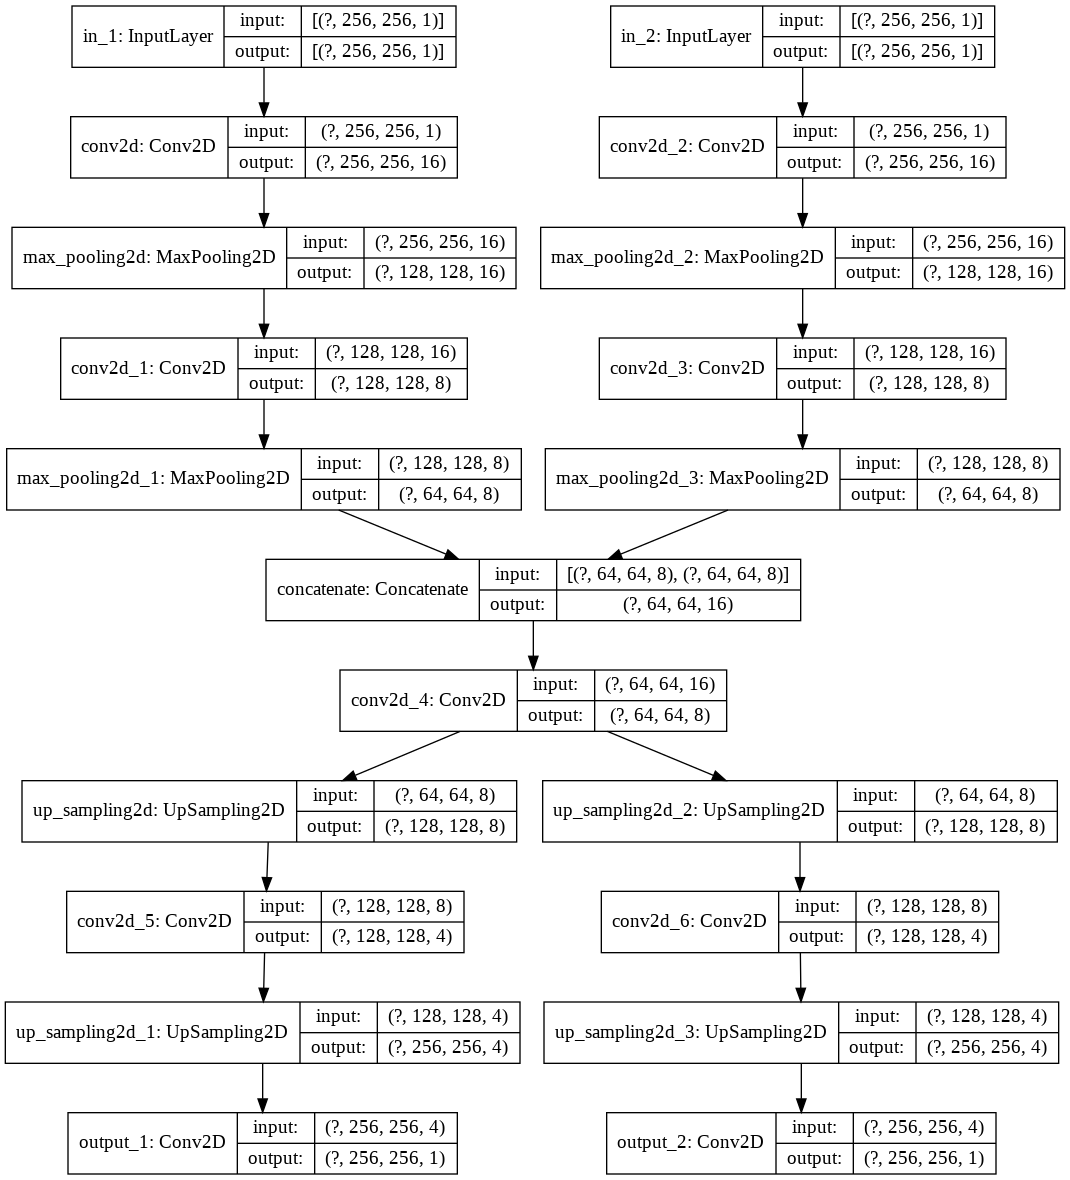

In [ ]:
# plot the model architecture
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-4)

In [ ]:
model.compile(optimizer=opt, loss=['binary_crossentropy', 'binary_crossentropy'], metrics=[['accuracy'], ['accuracy']])

In [ ]:
history = model.fit(train_generator,
    steps_per_epoch=np.ceil(89/16), 
    epochs=5,
    verbose=1,
    validation_data = val_generator,
    validation_steps=np.ceil(11/16))

Epoch 1/5
6/6 [==============================] - 14s 2s/step - loss: 1.3629 - output_1_loss: 0.6708 - output_2_loss: 0.6922 - output_1_accuracy: 0.7180 - output_2_accuracy: 0.6559 - val_loss: 1.3586 - val_output_1_loss: 0.6666 - val_output_2_loss: 0.6920 - val_output_1_accuracy: 0.7039 - val_output_2_accuracy: 0.7153
Epoch 2/5
6/6 [==============================] - 13s 2s/step - loss: 1.3568 - output_1_loss: 0.6650 - output_2_loss: 0.6918 - output_1_accuracy: 0.7211 - output_2_accuracy: 0.7642 - val_loss: 1.3521 - val_output_1_loss: 0.6604 - val_output_2_loss: 0.6917 - val_output_1_accuracy: 0.7046 - val_output_2_accuracy: 0.7894
Epoch 3/5
6/6 [==============================] - 13s 2s/step - loss: 1.3505 - output_1_loss: 0.6590 - output_2_loss: 0.6915 - output_1_accuracy: 0.7219 - output_2_accuracy: 0.8141 - val_loss: 1.3456 - val_output_1_loss: 0.6543 - val_output_2_loss: 0.6913 - val_output_1_accuracy: 0.7050 - val_output_2_accuracy: 0.8214
Epoch 4/5
6/6 [============================